# **Assignment Three**

In [1]:
#imports
import torch
import random
import os
import re
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split, WeightedRandomSampler
from PIL import Image
from scipy.spatial import cKDTree
import numpy as np
import torch.nn as nn
import timm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, hamming_loss, f1_score, precision_recall_fscore_support, confusion_matrix
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

C:\Users\wadalisam\AppData\Local\anaconda3\envs\research\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Setting Seed

In [2]:
def set_seed(seed=1):
    """
    Set seeds for reproducibility across all libraries
    
    This ensures:
    - Same train/test split every run
    - Same data augmentation sequence
    - Same weight initialization
    - Same results (as much as possible with GPU operations)
    """
    random.seed(seed)                      # Python random module
    np.random.seed(seed)                   # Numpy
    torch.manual_seed(seed)                # PyTorch CPU
    torch.cuda.manual_seed(seed)           # PyTorch GPU (single GPU)
    torch.cuda.manual_seed_all(seed)       # PyTorch GPU (multi-GPU)
    
    # Make CuDNN deterministic (may impact performance)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    # Set seed for DataLoader workers
    os.environ['PYTHONHASHSEED'] = str(seed)

## Preprocessing
### Extract Files

In [3]:
def extract_filename(filename):
    match = re.match(r'([-+]?\d*\.?\d+)\s+([-+]?\d*\.?\d+)', filename)
    if match:
        return float(match.group(1)), float(match.group(2))
    return None, None

### Extracting Filenames and matching Labels
*** need to match ones with their nearest neighbour 

In [4]:
def load_and_match_labels(labels_path, image_folders, distance_threshold=0.5):
    """Load labels and match them to image files"""
    
    # Load labels
    labels_data = []
    with open(labels_path, 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            if len(parts) >= 3:
                x_coord = float(parts[0].strip())
                y_coord = float(parts[1].strip())
                label_list = [part.strip() for part in parts[2:]]
                labels_data.append([x_coord, y_coord, label_list])
    
    labels = pd.DataFrame(labels_data, columns=["x_coord", "y_coord", "labels"])
    print(f"Loaded {len(labels)} labels from CSV")
    
    # Load image files from multiple folders
    file_entries = []
    for folder_idx, image_folder in enumerate(image_folders):
        if os.path.exists(image_folder):
            print(f"\nProcessing folder: {image_folder}")
            all_files = os.listdir(image_folder)
            print(f"Total files in folder: {len(all_files)}")
            
            for fname in all_files:
                if fname.endswith((".fits", ".FITS", ".png", ".PNG")):
                    x, y = extract_filename(fname)
                    if x is not None and y is not None:
                        file_entries.append([fname, x, y, folder_idx, image_folder])
    
    files_df = pd.DataFrame(file_entries, columns=["filename", "file_x", "file_y", "folder_idx", "folder_path"])
    print(f"\nTotal image files loaded: {len(files_df)}")
    
    # Match labels to files using KDTree
    coords_tree = cKDTree(files_df[["file_x", "file_y"]].values)
    distances, indices = coords_tree.query(labels[["x_coord", "y_coord"]].values)
    
    labels["matched_filename"] = files_df.iloc[indices]["filename"].values
    labels["matched_folder"] = files_df.iloc[indices]["folder_path"].values
    labels["match_distance"] = distances
    labels["match_quality"] = distances < distance_threshold
    
    print(f"\nMatching Statistics:")
    print(f"Mean distance: {distances.mean():.6f}")
    print(f"Max distance: {distances.max():.6f}")
    print(f"Matches within threshold ({distance_threshold}): {labels['match_quality'].sum()}")
    print(f"Poor matches: {(~labels['match_quality']).sum()}")
    
    return labels, files_df


### Multi-Label Encoding into Binary

In [5]:
def transform_labels_to_binary(labels_df):
    """Convert multi-label lists to binary columns"""
    
    # Find unique labels (exclude empty strings)
    all_unique_labels = sorted({
        label for sublist in labels_df["labels"] 
        for label in sublist 
        if label and label.strip()
    })
    
    print(f"\nFound {len(all_unique_labels)} unique labels:")
    print(all_unique_labels)
    
    # Create binary columns
    labels_binary = labels_df.copy()
    for label in all_unique_labels:
        labels_binary[label] = labels_binary["labels"].apply(
            lambda x: 1 if label in x else 0
        )
    
    # Print distribution
    print("\nLabel Distribution:")
    for label in all_unique_labels:
        count = labels_binary[label].sum()
        print(f"  {label}: {count} samples ({100*count/len(labels_binary):.1f}%)")
    
    return labels_binary, all_unique_labels

### Focal Loss

In [6]:
class FocalLoss(nn.Module):
    """
    Focal Loss focuses training on hard examples and down-weights easy negatives
    Much better than BCE for imbalanced datasets
    """
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        
    def forward(self, inputs, targets):
        BCE_loss = nn.functional.binary_cross_entropy_with_logits(
            inputs, targets, reduction='none'
        )
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        return torch.mean(F_loss)

### Normalize and Augment

In [7]:
def get_balanced_sampler(df, label_columns, alpha=0.75, rare_threshold=100):
    """
    Create WeightedRandomSampler with tunable inverse-frequency weighting and 
    support for targeted augmentation.
    
    Parameters:
    - alpha: Exponent for inverse-frequency (higher = more aggressive rare-class boosting)
    - rare_threshold: Threshold to identify rare classes (not used directly, but informative)
    
    Returns:
    - sampler: WeightedRandomSampler for DataLoader
    - rarity_scores: Per-sample rarity scores (0-1) for augmentation strength
    """
    print("\n-----------------------------------Creating Balanced Sampler-----------------------------------")
    
    # Compute counts for each label
    label_counts = {label: int(df[label].sum()) for label in label_columns}
    print("\nLabel frequencies:")
    for label, count in sorted(label_counts.items(), key=lambda x: x[1]):
        print(f"  {label:25s}: {count:4d} samples")
    
    # Compute sample weights + rarity scores
    sample_weights = []
    rarity_scores = []  # normalized rarity (0–1) for augmentation strength
    
    max_count = max(label_counts.values())
    min_count = min(label_counts.values())
    
    for _, row in df.iterrows():
        active_labels = [label for label in label_columns if row[label] == 1]
        
        if len(active_labels) == 0:
            weight = 1.0
            rarity = 0.0
        else:
            counts = np.array([label_counts[label] for label in active_labels])
            # Inverse frequency with power scaling
            inv_freqs = 1.0 / (counts ** alpha)
            weight = inv_freqs.mean()  # average instead of min
            
            # Rarity score: how rare is this sample on average?
            rarity = 1.0 - (counts.mean() - min_count) / (max_count - min_count)
        
        sample_weights.append(weight)
        rarity_scores.append(rarity)
    
    # Normalize weights so they sum to dataset size
    sample_weights = np.array(sample_weights)
    sample_weights = sample_weights / sample_weights.sum() * len(sample_weights)
    
    rarity_scores = np.array(rarity_scores)
    
    print(f"\nSample weight statistics:")
    print(f"  Min weight: {sample_weights.min():.4f}")
    print(f"  Max weight: {sample_weights.max():.4f}")
    print(f"  Mean weight: {sample_weights.mean():.4f}")
    print(f"  Median weight: {np.median(sample_weights):.4f}")
    
    print(f"\nRarity score statistics:")
    print(f"  Min rarity: {rarity_scores.min():.4f}")
    print(f"  Max rarity: {rarity_scores.max():.4f}")
    print(f"  Mean rarity: {rarity_scores.mean():.4f}")
    
    # Build sampler
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )
    
    print(f"\nBalanced sampler created with α={alpha}")
    print(f"  → Oversampling rare classes more aggressively")
    print(f"  → Higher α = stronger rare-class emphasis")
    print("="*60 + "\n")
    
    return sampler, rarity_scores


### Class Weights

In [8]:
def calculate_class_weights(train_df, label_columns):
    """
    Calculate pos_weight for BCEWithLogitsLoss (if using weighted BCE instead of Focal)
    """
    pos_weights = []
    
    print("\nClass Weights:")
    print("="*80)
    for label in label_columns:
        pos_count = train_df[label].sum()
        neg_count = len(train_df) - pos_count
        
        if pos_count == 0:
            pos_weight = 1.0
        else:
            pos_weight = neg_count / pos_count
        
        pos_weights.append(pos_weight)
        print(f"{label:25s} | Pos: {int(pos_count):4d} | "
              f"Neg: {int(neg_count):4d} | Weight: {pos_weight:6.2f}")
    
    print("="*80)
    
    return torch.tensor(pos_weights, dtype=torch.float32)

### Custom Dataset

In [9]:
class RadioDataset(Dataset):
    def __init__(self, df, label_columns, rarity_scores=None, base_aug_strength=0.5, 
                 mode='train', transform=None):
        """
        Custom dataset with rarity-based adaptive augmentation
        
        Parameters:
        - df: DataFrame with image paths and labels
        - label_columns: List of label column names
        - rarity_scores: Array of rarity scores (0-1) per sample
        - base_aug_strength: Base probability for strong augmentation
        - mode: 'train' or 'test' (affects augmentation)
        - transform: Optional fixed transform (overrides adaptive augmentation)
        """
        self.df = df.reset_index(drop=True)
        self.label_columns = label_columns
        self.num_classes = len(label_columns)
        self.rarity_scores = rarity_scores if rarity_scores is not None else np.zeros(len(df))
        self.base_aug_strength = base_aug_strength
        self.mode = mode
        self.fixed_transform = transform
        
        # Define base transforms (always applied)
        self.base_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
        ])
        
        # Weak augmentation (for common classes)
        self.weak_aug = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
        ])
        
        # Strong augmentation (for rare classes)
        self.strong_aug = transforms.Compose([
            transforms.RandomRotation(180),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ColorJitter(brightness=0.4, contrast=0.4),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        fname = row["matched_filename"]
        folder = row["matched_folder"]
        
        # Extract binary labels
        label_values = row[self.label_columns].values.astype(np.float32)
        labels = torch.tensor(label_values, dtype=torch.float32)
        
        # Load image
        img_path = os.path.join(folder, fname)
        image = Image.open(img_path).convert("RGB")
        
        # Apply augmentation based on mode and rarity
        if self.fixed_transform is not None:
            # Use fixed transform if provided (for backward compatibility)
            image = self.fixed_transform(image)
        elif self.mode == 'train':
            # Adaptive augmentation based on rarity
            rarity = self.rarity_scores[idx]
            prob_strong_aug = self.base_aug_strength + (0.5 * rarity)  # 0.5 to 1.0 range
            
            if random.random() < prob_strong_aug:
                # Apply strong augmentation for rare samples
                image = self.strong_aug(image)
            else:
                # Apply weak augmentation for common samples
                image = self.weak_aug(image)
            
            # Always apply base transform (resize, normalize)
            image = self.base_transform(image)
        else:
            # Test mode: only base transform
            image = self.base_transform(image)
        
        return image, labels

### EfficientNet Model

In [10]:
class EfficientNetMultiLabel(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        self.model = timm.create_model('efficientnet_b2', pretrained=pretrained)
        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)

### Evaluating

In [11]:
def evaluate_model(model, dataloader, label_columns, device, show_confusion_matrix=True):
    """Evaluate model and return detailed metrics"""
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating"):
            images = images.to(device)
            outputs = model(images)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).cpu().numpy()
            
            all_preds.append(preds)
            all_labels.append(labels.numpy())
            all_probs.append(probs.cpu().numpy())
    
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    all_probs = np.vstack(all_probs)
    
    # Per-class metrics
    print("\n--------------------------Metrics Per Class----------------------------------------------------------")
    
    results = {}
    confusion_matrices = {}
    
    for i, label in enumerate(label_columns):
        precision, recall, f1, _ = precision_recall_fscore_support(
            all_labels[:, i], all_preds[:, i], average='binary', zero_division=0
        )
        
        # Calculate accuracy for this class
        accuracy = np.mean(all_labels[:, i] == all_preds[:, i])
        
        # Calculate confusion matrix for this class
        cm = confusion_matrix(all_labels[:, i], all_preds[:, i], labels=[0, 1])
        confusion_matrices[label] = cm
        
        tn, fp, fn, tp = cm.ravel()
        
        # Calculate support from confusion matrix
        actual_support = int(tp + fn)
        
        results[label] = {
            'precision': precision, 
            'recall': recall, 
            'f1': f1, 
            'support': actual_support,
            'accuracy': accuracy,
            'confusion_matrix': cm,
            'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp
        }
        print(f"{label:25s} | P: {precision:.3f} | R: {recall:.3f} | F1: {f1:.3f} | Acc: {accuracy:.3f} | Support: {actual_support}")
    
    # Overall metrics
    hamming = hamming_loss(all_labels, all_preds)
    subset_accuracy = np.mean(np.all(all_preds == all_labels, axis=1))
    
    # Micro and Macro averages
    micro_precision, micro_recall, micro_f1, _ = precision_recall_fscore_support(
        all_labels.flatten(), all_preds.flatten(), average='micro', zero_division=0
    )
    macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='macro', zero_division=0
    )
    
    print("\n-------------------Overall Metrics-------------------------------------------------------")
    
    print(f"Hamming Loss:        {hamming:.4f}  (lower is better)")
    print(f"Subset Accuracy:     {subset_accuracy:.4f}  (exact match for all labels)")
    print(f"\nMicro Averages:  (treats all label instances equally)")
    print(f"  Precision:         {micro_precision:.4f}")
    print(f"  Recall:            {micro_recall:.4f}")
    print(f"  F1-Score:          {micro_f1:.4f}")
    print(f"\nMacro Averages:  (treats all classes equally)")
    print(f"  Precision:         {macro_precision:.4f}")
    print(f"  Recall:            {macro_recall:.4f}")
    print(f"  F1-Score:          {macro_f1:.4f}")
    print("="*60 + "\n")
    
    # Plot confusion matrices if requested
    if show_confusion_matrix:
        plot_confusion_matrices(confusion_matrices, label_columns)
    
    return all_preds, all_labels, all_probs, results

### Plotting Confusion Matrices

In [12]:
def plot_confusion_matrices(confusion_matrices, label_columns, save_path='confusion_matrices.png'):
    """Plot confusion matrices for all classes in a grid"""
    
    n_classes = len(label_columns)
    n_cols = int(np.ceil(np.sqrt(n_classes)))
    n_rows = int(np.ceil(n_classes / n_cols))
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
    
    if n_classes == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    for idx, label in enumerate(label_columns):
        cm = confusion_matrices[label]
        ax = axes[idx]
        
        # Plot heatmap
        im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        
        # Set title and labels
        ax.set_title(f'{label}\n(Support: {cm[1,1] + cm[1,0]})', fontsize=11, fontweight='bold')
        ax.set_ylabel('True Label', fontsize=10)
        ax.set_xlabel('Predicted Label', fontsize=10)
        
        # Set tick labels
        ax.set_xticks([0, 1])
        ax.set_yticks([0, 1])
        ax.set_xticklabels(['Negative', 'Positive'], fontsize=9)
        ax.set_yticklabels(['Negative', 'Positive'], fontsize=9)
        
        # Add text annotations
        thresh = cm.max() / 2.
        for i in range(2):
            for j in range(2):
                text_color = "white" if cm[i, j] > thresh else "black"
                
                ax.text(j, i, f'{cm[i, j]}',
                       ha="center", va="center",
                       color=text_color, fontsize=14, fontweight='bold')
                
                if i == 0 and j == 0:
                    label_text = 'TN'
                elif i == 0 and j == 1:
                    label_text = 'FP'
                elif i == 1 and j == 0:
                    label_text = 'FN'
                else:
                    label_text = 'TP'
                
                ax.text(j, i + 0.3, label_text,
                       ha="center", va="center",
                       color=text_color, fontsize=8, style='italic')
    
    # Hide empty subplots
    for idx in range(n_classes, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    print(f"Confusion matrices saved")
    plt.show()
    
    return fig

### Confusion Matrix Summary

In [13]:
def print_confusion_matrix_summary(results, label_columns):
    """Print a summary table of confusion matrix values"""
    print("\n-------------------------Confusion Matrix Summary---------------------------------------------------------\n")
    print("="*80)
    print(f"{'Class':<25} | {'TP':>6} | {'FP':>6} | {'FN':>6} | {'TN':>6} | {'Sensitivity':>11} | {'Specificity':>11}")
    print("-"*80)
    
    for label in label_columns:
        tp = results[label]['tp']
        fp = results[label]['fp']
        fn = results[label]['fn']
        tn = results[label]['tn']
        
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        
        print(f"{label:<25} | {tp:>6} | {fp:>6} | {fn:>6} | {tn:>6} | {sensitivity:>11.3f} | {specificity:>11.3f}")
    
    print("="*80)
    print("TP: True Positives  | FP: False Positives | FN: False Negatives | TN: True Negatives")
    print("Sensitivity: TP/(TP+FN) = Recall | Specificity: TN/(TN+FP)")
    print("="*80 + "\n")


### Visualizer

In [14]:
def visualize_predictions(model, dataset, label_columns, device, num_samples=6):
    """Visualize sample images with predictions vs ground truth"""
    
    model.eval()
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    with torch.no_grad():
        for idx, sample_idx in enumerate(indices):
            image, true_labels = dataset[sample_idx]
            
            # Get prediction
            image_batch = image.unsqueeze(0).to(device)
            outputs = model(image_batch)
            probs = torch.sigmoid(outputs).cpu().numpy()[0]
            preds = (probs > 0.5).astype(int)
            
            # Denormalize image
            img_display = image.permute(1, 2, 0).numpy()
            img_display = (img_display * 0.5) + 0.5
            img_display = np.clip(img_display, 0, 1)
            
            # Plot
            axes[idx].imshow(img_display)
            axes[idx].axis('off')
            
            # Get labels
            pred_labels = [label_columns[i] for i, p in enumerate(preds) if p == 1]
            true_label_names = [label_columns[i] for i, t in enumerate(true_labels) if t == 1]
            pred_confidences = [probs[i] for i, p in enumerate(preds) if p == 1]
            
            # Format
            if len(pred_labels) == 0:
                pred_text = "None"
            else:
                pred_text = "\n".join([f"{l} ({c:.2f})" for l, c in zip(pred_labels, pred_confidences)])
            
            if len(true_label_names) == 0:
                true_text = "None"
            else:
                true_text = ", ".join(true_label_names)
            
            correct = np.array_equal(preds, true_labels.numpy())
            color = 'green' if correct else 'red'
            
            axes[idx].set_title(
                f"Predicted:\n{pred_text}\n\nTrue: {true_text}",
                fontsize=9, color=color, weight='bold'
            )
    
    plt.tight_layout()
    plt.savefig('sample_predictions.png', dpi=150, bbox_inches='tight')
    print("Sample predictions saved")
    plt.show()
    
    return fig

### Training 

In [15]:
def train_model(model, train_loader, test_loader, criterion, optimizer, 
                num_epochs, device, label_columns, save_path='best_model.pth',
                eval_threshold=0.5, scheduler=None):
    """Core training loop with validation"""
    
    train_losses = []
    test_losses = []
    test_f1_scores = []
    best_f1 = 0.0
    
    for epoch in range(num_epochs):
        # ========== TRAINING ==========
        model.train()
        running_loss = 0.0
        
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for images, labels in pbar:
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # ========== VALIDATION ==========
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                probs = torch.sigmoid(outputs)
                preds = (probs > eval_threshold).cpu().numpy()
                
                all_preds.append(preds)
                all_labels.append(labels.cpu().numpy())
        
        avg_test_loss = val_loss / len(test_loader)
        test_losses.append(avg_test_loss)
        
        # Calculate F1 scores
        all_preds = np.vstack(all_preds)
        all_labels = np.vstack(all_labels)
        
        class_f1_scores = []
        for i in range(len(label_columns)):
            _, _, f1, _ = precision_recall_fscore_support(
                all_labels[:, i], all_preds[:, i], 
                average='binary', zero_division=0
            )
            class_f1_scores.append(f1)
        
        macro_f1 = np.mean(class_f1_scores)
        test_f1_scores.append(macro_f1)
        
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print(f"  Train Loss: {avg_train_loss:.4f}")
        print(f"  Test Loss:   {avg_test_loss:.4f}")
        print(f"  Macro F1:   {macro_f1:.4f}")
        
        # Save best model
        if macro_f1 > best_f1:
            best_f1 = macro_f1
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'macro_f1': macro_f1,
                'class_f1_scores': class_f1_scores,
                'train_loss': avg_train_loss,
                'test_loss': avg_test_loss
            }, save_path)
            print(f"  New best model saved (F1: {best_f1:.4f})")
        
        # Learning rate scheduling
        if scheduler is not None:
            scheduler.step(macro_f1)
        
        print()
    
    return train_losses, test_losses, test_f1_scores

In [16]:
def train_all(model, train_df, label_columns, device,
                        num_epochs=15, learning_rate=1e-4, 
                        batch_size=32, use_focal_loss=True, 
                        sampler_alpha=0.75, eval_threshold=0.3, 
                        val_split=0.0, test_df=None, save_path='best_model.pth'):
    """
    Complete training pipeline with all class imbalance fixes
    
    Parameters:
    - use_focal_loss: If True, use Focal Loss; if False, use BCE
    - sampler_alpha: Higher = more aggressive rare-class oversampling (0.5-1.0)
    - eval_threshold: Prediction threshold for evaluation (0.3 recommended)
    - val_split: Fraction of data for validation (0.0 = use test_df, >0 = create val split)
    - test_df: External test dataframe (used when val_split=0.0)
    """
    
    print("\n----------------------Training----------------------------------------\n")
    
    # Create train/val split OR use external test set
    if val_split > 0.0:
        # Create validation split from training data
        train_indices, val_indices = train_test_split(
            range(len(train_df)), 
            test_size=val_split, 
            random_state=42,
            stratify=train_df[label_columns].sum(axis=1).apply(lambda x: min(x, 3))
        )
        
        train_split_df = train_df.iloc[train_indices].reset_index(drop=True)
        val_df = train_df.iloc[val_indices].reset_index(drop=True)
        
        print(f"\nDataset split:")
        print(f"  Training:   {len(train_split_df)} samples ({(1-val_split)*100:.0f}%)")
        print(f"  Validation: {len(val_df)} samples ({val_split*100:.0f}%)")
    else:
        # Use external test set for validation
        if test_df is None:
            raise ValueError("When val_split=0.0, test_df must be provided")
        
        train_split_df = train_df.reset_index(drop=True)
        val_df = test_df.reset_index(drop=True)
        
        print(f"\nDataset split:")
        print(f"  Training: {len(train_split_df)} samples (using full training set)")
        print(f"  Test:     {len(val_df)} samples (external test set for evaluation)")
    
    # Create balanced sampler
    sampler, rarity_scores = get_balanced_sampler(
        train_split_df, label_columns, alpha=sampler_alpha
    )
    
    # Create datasets
    train_dataset = RadioDataset(
        df=train_split_df, label_columns=label_columns,
        rarity_scores=rarity_scores, mode='train'
    )
    
    val_dataset = RadioDataset(
        df=val_df, label_columns=label_columns, mode='test'
    )
    
    # Create dataloaders
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size,
        sampler=sampler, num_workers=0
    )
    
    test_loader = DataLoader(
        val_dataset, batch_size=batch_size,
        shuffle=False, num_workers=0
    )
    
    # Setup loss function
    if use_focal_loss:
        criterion = FocalLoss(alpha=0.25, gamma=2.0)
        loss_name = "Focal Loss"
    else:
        criterion = nn.BCEWithLogitsLoss()
        loss_name = "BCE Loss"
    
    # Setup optimizer and scheduler
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=3, verbose=True
    )
    
    print(f"\nTraining Configuration:")
    print(f"  Loss Function:  {loss_name}")
    print(f"  Sampler Alpha:  {sampler_alpha}")
    print(f"  Learning Rate:  {learning_rate}")
    print(f"  Batch Size:     {batch_size}")
    print(f"  Epochs:         {num_epochs}")
    print(f"  Eval Threshold: {eval_threshold}")
    print()
    
    # Train the model
    train_losses, test_losses, test_f1_scores = train_model(
        model=model, train_loader=train_loader, test_loader=test_loader,
        criterion=criterion, optimizer=optimizer, num_epochs=num_epochs,
        device=device, label_columns=label_columns, save_path=save_path,
        eval_threshold=eval_threshold, scheduler=scheduler
    )
    
    # Load best model
    checkpoint = torch.load(save_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    print(f"\n✓ Loaded best model from {save_path}")
    print(f"\nFinal per-class F1 scores:")
    for label, f1 in zip(label_columns, checkpoint['class_f1_scores']):
        print(f"  {label:25s}: {f1:.3f}")
    
    return model, train_losses, test_losses, test_f1_scores, checkpoint

## Predictions

In [17]:
def predict_provided_test_set(model, test_csv_path, image_folders, label_columns, 
                              device, output_path='test_labels.csv'):
    """Generate predictions for the provided test.csv file"""
    
    # Load test coordinates
    test_coords = pd.read_csv(test_csv_path, header=None, names=['x_coord', 'y_coord'])
    print(f"Loaded {len(test_coords)} test coordinates")
    
    # Match to images
    file_entries = []
    for folder in image_folders:
        if os.path.exists(folder):
            for fname in os.listdir(folder):
                if fname.endswith((".fits", ".FITS", ".png", ".PNG")):
                    x, y = extract_filename(fname)
                    if x is not None and y is not None:
                        file_entries.append([fname, x, y, folder])
    
    files_df = pd.DataFrame(file_entries, columns=["filename", "file_x", "file_y", "folder_path"])
    
    # Match using KDTree
    coords_tree = cKDTree(files_df[["file_x", "file_y"]].values)
    distances, indices = coords_tree.query(test_coords[["x_coord", "y_coord"]].values)
    
    test_coords["matched_filename"] = files_df.iloc[indices]["filename"].values
    test_coords["matched_folder"] = files_df.iloc[indices]["folder_path"].values
    
    # Create dummy labels (will be replaced by predictions)
    for label in label_columns:
        test_coords[label] = 0
    
    # Create dataset
    test_dataset = RadioDataset(
    df=test_coords, 
    label_columns=label_columns,
    mode='test'
    )
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    # Generate predictions
    model.eval()
    all_preds = []
    
    with torch.no_grad():
        for images, _ in tqdm(test_loader, desc="Predicting on provided test.csv"):
            outputs = model(images.to(device))
            preds = (torch.sigmoid(outputs) > 0.5).cpu().numpy()
            all_preds.append(preds)
    
    all_preds = np.vstack(all_preds)
    
    # Create output
    result = test_coords[['x_coord', 'y_coord']].copy()
    for i, label in enumerate(label_columns):
        result[label] = all_preds[:, i].astype(int)
    
    result.to_csv(output_path, index=False)
    print(f"\nSaved predictions to {output_path}")
    
    return result

### Main Function

Using device: cpu


----------------------------Loading Datasets >> Matching Labels---------------------------------------------

Loaded 2178 labels from CSV

Processing folder: typ/typ_PNG/
Total files in folder: 2049

Processing folder: exo/exo_PNG/
Total files in folder: 59

Total image files loaded: 2107

Matching Statistics:
Mean distance: 0.015305
Max distance: 1.263159
Matches within threshold (0.5): 2172
Poor matches: 6

Found 9 unique labels:
['Bent', 'Exotic', 'FR I', 'FR II', 'Point Source', 'S/Z shaped', 'Should be discarded', 'X-Shaped', 'typical']

Label Distribution:
  Bent: 525 samples (24.1%)
  Exotic: 56 samples (2.6%)
  FR I: 431 samples (19.8%)
  FR II: 683 samples (31.4%)
  Point Source: 442 samples (20.3%)
  S/Z shaped: 21 samples (1.0%)
  Should be discarded: 200 samples (9.2%)
  X-Shaped: 6 samples (0.3%)
  typical: 24 samples (1.1%)

Dataset Overview:
  Total samples: 2178
  Number of classes: 9
  Classes: Bent, Exotic, FR I, FR II, Point Source, S/Z shaped, Sh

Epoch 1/25: 100%|██████████| 62/62 [03:50<00:00,  3.72s/it, loss=0.0260]



Epoch 1/25
  Train Loss: 0.0256
  Test Loss:   0.0210
  Macro F1:   0.2615
  New best model saved (F1: 0.2615)



Epoch 2/25: 100%|██████████| 62/62 [03:39<00:00,  3.54s/it, loss=0.0174]



Epoch 2/25
  Train Loss: 0.0191
  Test Loss:   0.0175
  Macro F1:   0.2995
  New best model saved (F1: 0.2995)



Epoch 3/25: 100%|██████████| 62/62 [03:38<00:00,  3.52s/it, loss=0.0178]



Epoch 3/25
  Train Loss: 0.0174
  Test Loss:   0.0205
  Macro F1:   0.2914



Epoch 4/25: 100%|██████████| 62/62 [03:39<00:00,  3.55s/it, loss=0.0223]



Epoch 4/25
  Train Loss: 0.0161
  Test Loss:   1.1065
  Macro F1:   0.3203
  New best model saved (F1: 0.3203)



Epoch 5/25: 100%|██████████| 62/62 [03:42<00:00,  3.59s/it, loss=0.0158]



Epoch 5/25
  Train Loss: 0.0146
  Test Loss:   0.0585
  Macro F1:   0.2769



Epoch 6/25: 100%|██████████| 62/62 [03:45<00:00,  3.64s/it, loss=0.0117]



Epoch 6/25
  Train Loss: 0.0140
  Test Loss:   0.0347
  Macro F1:   0.2925



Epoch 7/25: 100%|██████████| 62/62 [03:33<00:00,  3.45s/it, loss=0.0189]



Epoch 7/25
  Train Loss: 0.0133
  Test Loss:   0.1236
  Macro F1:   0.3042



Epoch 8/25: 100%|██████████| 62/62 [03:38<00:00,  3.52s/it, loss=0.0197]



Epoch 8/25
  Train Loss: 0.0132
  Test Loss:   0.0204
  Macro F1:   0.3237
  New best model saved (F1: 0.3237)



Epoch 9/25: 100%|██████████| 62/62 [03:39<00:00,  3.54s/it, loss=0.0136]



Epoch 9/25
  Train Loss: 0.0124
  Test Loss:   0.0466
  Macro F1:   0.3201



Epoch 10/25: 100%|██████████| 62/62 [03:40<00:00,  3.56s/it, loss=0.0191]



Epoch 10/25
  Train Loss: 0.0122
  Test Loss:   0.0564
  Macro F1:   0.2813



Epoch 11/25: 100%|██████████| 62/62 [03:39<00:00,  3.53s/it, loss=0.0167]



Epoch 11/25
  Train Loss: 0.0115
  Test Loss:   0.0375
  Macro F1:   0.2902



Epoch 12/25: 100%|██████████| 62/62 [03:39<00:00,  3.54s/it, loss=0.0281]



Epoch 12/25
  Train Loss: 0.0112
  Test Loss:   0.1070
  Macro F1:   0.2785



Epoch 13/25: 100%|██████████| 62/62 [03:38<00:00,  3.52s/it, loss=0.0182]



Epoch 13/25
  Train Loss: 0.0109
  Test Loss:   0.0198
  Macro F1:   0.2868



Epoch 14/25: 100%|██████████| 62/62 [03:37<00:00,  3.50s/it, loss=0.0148]



Epoch 14/25
  Train Loss: 0.0106
  Test Loss:   0.0285
  Macro F1:   0.3056



Epoch 15/25: 100%|██████████| 62/62 [03:46<00:00,  3.66s/it, loss=0.0161]



Epoch 15/25
  Train Loss: 0.0103
  Test Loss:   0.0241
  Macro F1:   0.2972



Epoch 16/25: 100%|██████████| 62/62 [04:04<00:00,  3.94s/it, loss=0.0097]



Epoch 16/25
  Train Loss: 0.0098
  Test Loss:   0.0236
  Macro F1:   0.2934



Epoch 17/25: 100%|██████████| 62/62 [04:01<00:00,  3.89s/it, loss=0.0133]



Epoch 17/25
  Train Loss: 0.0095
  Test Loss:   0.0297
  Macro F1:   0.3007



Epoch 18/25: 100%|██████████| 62/62 [04:00<00:00,  3.88s/it, loss=0.0119]



Epoch 18/25
  Train Loss: 0.0096
  Test Loss:   0.0212
  Macro F1:   0.2901



Epoch 19/25: 100%|██████████| 62/62 [03:58<00:00,  3.84s/it, loss=0.0122]



Epoch 19/25
  Train Loss: 0.0096
  Test Loss:   0.0192
  Macro F1:   0.2887



Epoch 20/25: 100%|██████████| 62/62 [04:00<00:00,  3.87s/it, loss=0.0175]



Epoch 20/25
  Train Loss: 0.0091
  Test Loss:   0.0743
  Macro F1:   0.3049



Epoch 21/25: 100%|██████████| 62/62 [04:03<00:00,  3.92s/it, loss=0.0083]



Epoch 21/25
  Train Loss: 0.0089
  Test Loss:   0.0247
  Macro F1:   0.2990



Epoch 22/25: 100%|██████████| 62/62 [03:48<00:00,  3.68s/it, loss=0.0122]



Epoch 22/25
  Train Loss: 0.0094
  Test Loss:   0.0345
  Macro F1:   0.3024



Epoch 23/25: 100%|██████████| 62/62 [03:49<00:00,  3.71s/it, loss=0.0146]



Epoch 23/25
  Train Loss: 0.0089
  Test Loss:   0.0195
  Macro F1:   0.2924



Epoch 24/25: 100%|██████████| 62/62 [03:55<00:00,  3.80s/it, loss=0.0114]



Epoch 24/25
  Train Loss: 0.0089
  Test Loss:   0.0196
  Macro F1:   0.3017



Epoch 25/25: 100%|██████████| 62/62 [03:53<00:00,  3.76s/it, loss=0.0093]



Epoch 25/25
  Train Loss: 0.0088
  Test Loss:   0.0290
  Macro F1:   0.2939


✓ Loaded best model from best_model.pth

Final per-class F1 scores:
  Bent                     : 0.447
  Exotic                   : 0.222
  FR I                     : 0.414
  FR II                    : 0.660
  Point Source             : 0.641
  S/Z shaped               : 0.000
  Should be discarded      : 0.196
  X-Shaped                 : 0.000
  typical                  : 0.333


--------------------------------------Training Curves------------------------------------------------
 
✓ Training curves saved to 'training_curves.png'


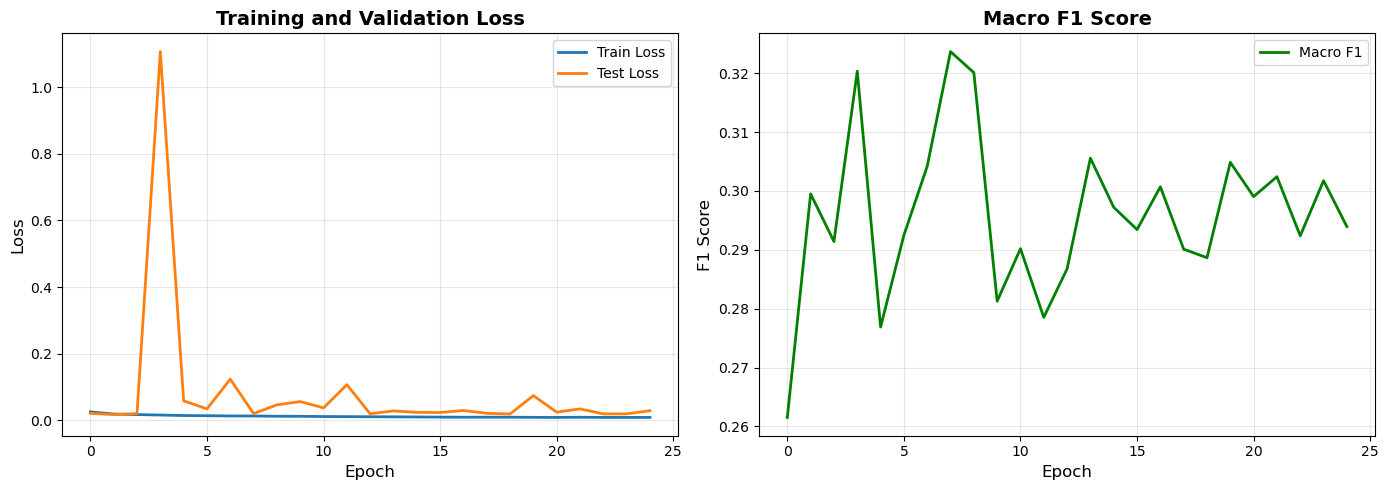


STEP 6: Final Evaluation on Test Set


Evaluating: 100%|██████████| 7/7 [00:04<00:00,  1.48it/s]



--------------------------Metrics Per Class----------------------------------------------------------
Bent                      | P: 0.333 | R: 0.208 | F1: 0.256 | Acc: 0.734 | Support: 48
Exotic                    | P: 0.500 | R: 0.400 | F1: 0.444 | Acc: 0.977 | Support: 5
FR I                      | P: 0.400 | R: 0.471 | F1: 0.432 | Acc: 0.807 | Support: 34
FR II                     | P: 0.727 | R: 0.580 | F1: 0.645 | Acc: 0.798 | Support: 69
Point Source              | P: 0.816 | R: 0.596 | F1: 0.689 | Acc: 0.872 | Support: 52
S/Z shaped                | P: 0.000 | R: 0.000 | F1: 0.000 | Acc: 0.986 | Support: 3
Should be discarded       | P: 0.500 | R: 0.043 | F1: 0.080 | Acc: 0.894 | Support: 23
X-Shaped                  | P: 0.000 | R: 0.000 | F1: 0.000 | Acc: 1.000 | Support: 0
typical                   | P: 0.000 | R: 0.000 | F1: 0.000 | Acc: 0.991 | Support: 2

-------------------Overall Metrics-------------------------------------------------------
Hamming Loss:        0.1045

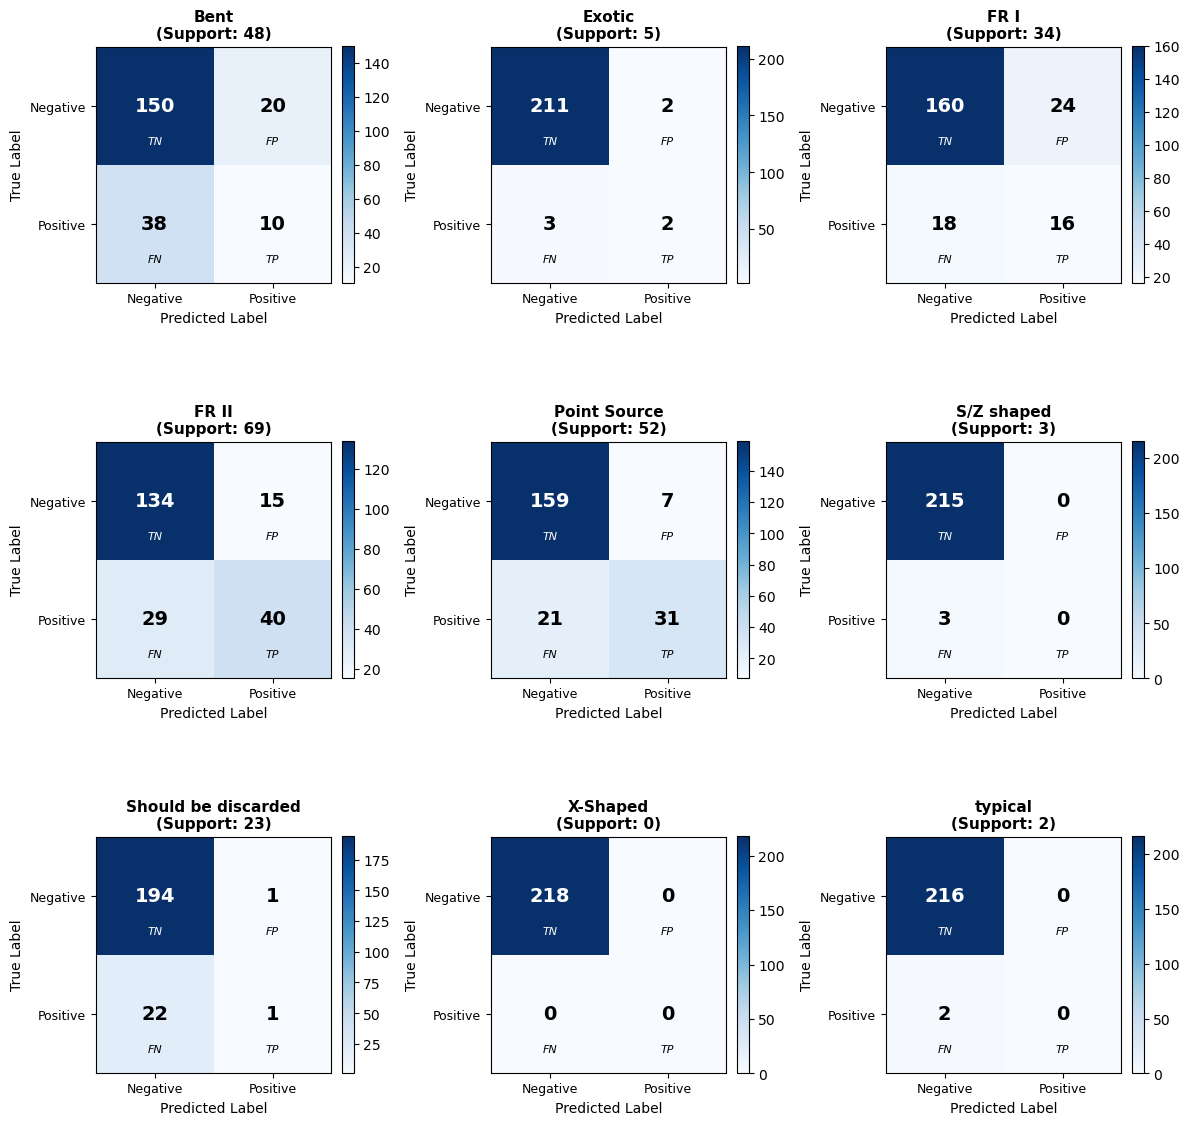


-------------------------Confusion Matrix Summary---------------------------------------------------------

Class                     |     TP |     FP |     FN |     TN | Sensitivity | Specificity
--------------------------------------------------------------------------------
Bent                      |     10 |     20 |     38 |    150 |       0.208 |       0.882
Exotic                    |      2 |      2 |      3 |    211 |       0.400 |       0.991
FR I                      |     16 |     24 |     18 |    160 |       0.471 |       0.870
FR II                     |     40 |     15 |     29 |    134 |       0.580 |       0.899
Point Source              |     31 |      7 |     21 |    159 |       0.596 |       0.958
S/Z shaped                |      0 |      0 |      3 |    215 |       0.000 |       1.000
Should be discarded       |      1 |      1 |     22 |    194 |       0.043 |       0.995
X-Shaped                  |      0 |      0 |      0 |    218 |       0.000 |       1.000


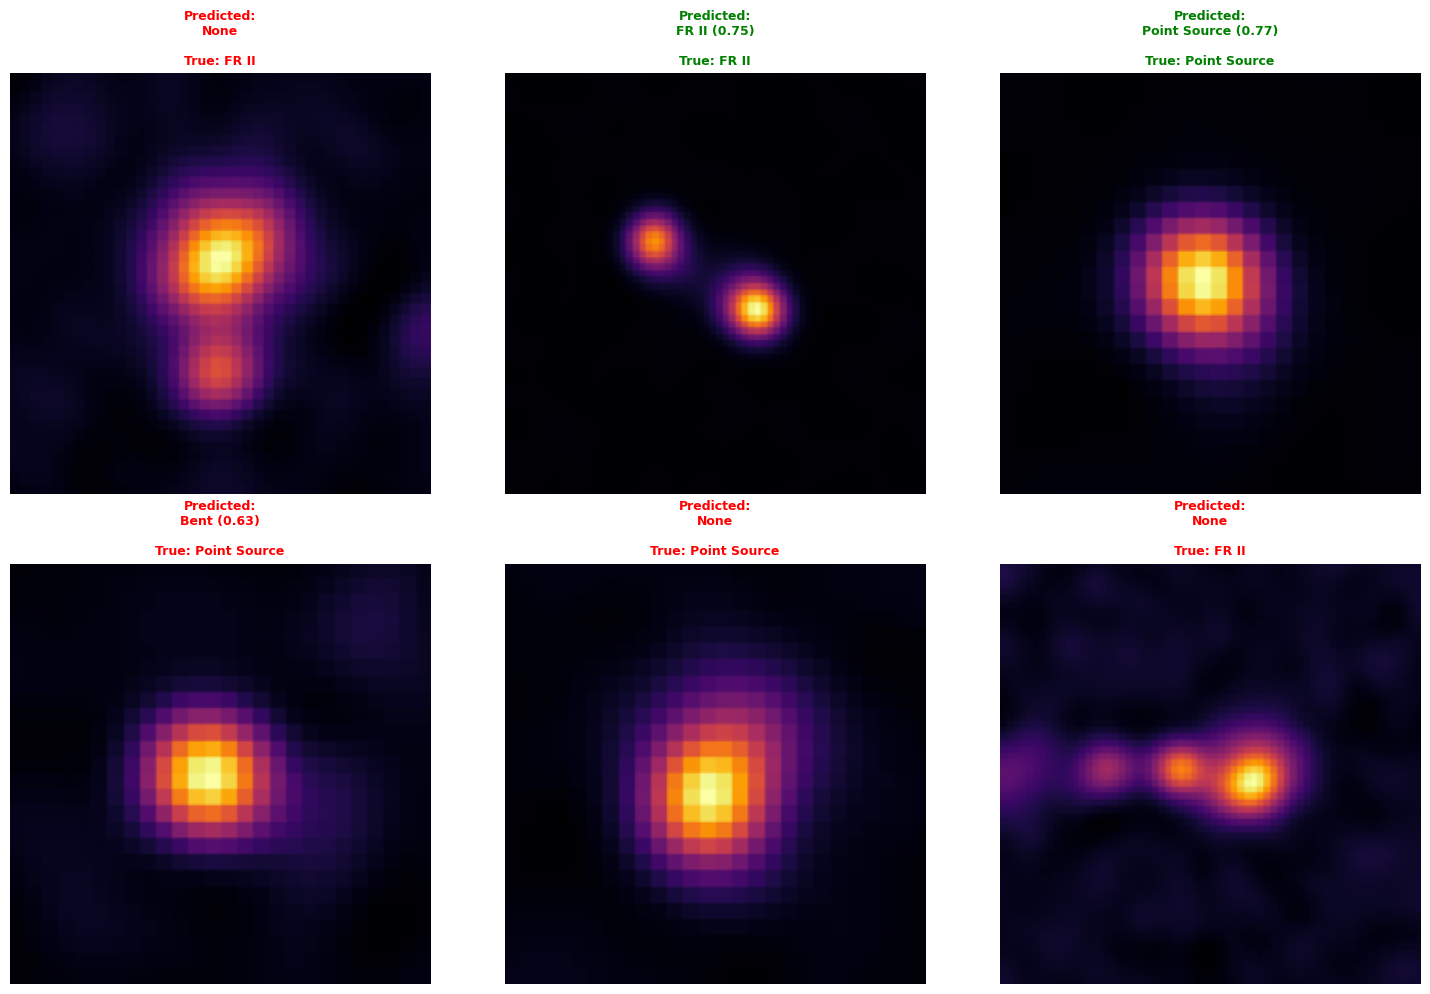


----------------------------------------Predicting on Test.csv--------------------------------------------

Loaded 100 test coordinates


Predicting on provided test.csv: 100%|██████████| 4/4 [00:02<00:00,  1.80it/s]


Saved predictions to test_labels.csv
 Predictions saved for 100 test samples

--------------------------------TRAINING COMPLETE!---------------------------------------------------


Best model saved to: best_model.pth
Best validation macro F1: 0.3237
Achieved at epoch: 8


In [18]:
if __name__ == "__main__":
    
    # SET SEED FIRST
    SEED = 42
    set_seed(SEED)
    
    # Configuration
    LABELS_PATH = "labels.csv"
    IMAGE_FOLDERS = ["typ/typ_PNG/", "exo/exo_PNG/"]
    TEST_CSV_PATH = "test.csv"
    BATCH_SIZE = 32
    NUM_EPOCHS = 25
    LEARNING_RATE = 1e-4
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    print(f"Using device: {DEVICE}\n")
    
    # Step 1: Load and match labels
    print("\n----------------------------Loading Datasets >> Matching Labels---------------------------------------------\n")

    labels, files_df = load_and_match_labels(LABELS_PATH, IMAGE_FOLDERS)
    
    # Step 2: Transform to binary
    labels_binary, label_columns = transform_labels_to_binary(labels)
    
    print(f"\nDataset Overview:")
    print(f"  Total samples: {len(labels_binary)}")
    print(f"  Number of classes: {len(label_columns)}")
    print(f"  Classes: {', '.join(label_columns)}")
    
    # Step 3: Split into train/test (90/10 split)
    print("\n-------------------------------Train/Test Split----------------------------------------\n")
    
    train_df = labels_binary.sample(frac=0.9, random_state=SEED)
    test_df = labels_binary.drop(train_df.index)
    
    print(f"Train set: {len(train_df)} samples (90%)")
    print(f"Test set:  {len(test_df)} samples (10%)")
    
    # Step 4: Create model
    print("\n--------------------------------------------------Model Creation----------------------------------------\n")

    
    num_classes = len(label_columns)
    model = EfficientNetMultiLabel(num_classes=num_classes, pretrained=True)
    model = model.to(DEVICE)
    
    print(f"Model: EfficientNet-B2 with {num_classes} output classes")
    print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
    print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
    
    # Step 5: Train model with ALL imbalance fixes
    print("\n-------------------------------------Training------------------------------------------------------------------")

    model, train_losses, test_losses, f1_scores, checkpoint = train_all(
        model=model,
        train_df=train_df,
        label_columns=label_columns,
        device=DEVICE,
        num_epochs=NUM_EPOCHS,
        learning_rate=LEARNING_RATE,
        batch_size=BATCH_SIZE,
        use_focal_loss=True,           # Use Focal Loss instead of BCE
        sampler_alpha=0.75,             # Aggressive oversampling of rare classes
        eval_threshold=0.3,             # Lower threshold for rare class detection
        val_split=0.0,                  # NO validation split
        save_path='best_model.pth',
        test_df=test_df                 # Pass test_df for evaluation
    )
    
    # Step 6: Plot training curves
    print("\n" + "="*80)
    print("\n--------------------------------------Training Curves------------------------------------------------\n ")
    print("="*80)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Loss plot
    axes[0].plot(train_losses, label='Train Loss', linewidth=2)
    axes[0].plot(test_losses, label='Test Loss', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # F1 score plot
    axes[1].plot(f1_scores, label='Macro F1', linewidth=2, color='green')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('F1 Score', fontsize=12)
    axes[1].set_title('Macro F1 Score', fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
    print("✓ Training curves saved to 'training_curves.png'")
    plt.show()
    
    # Step 7: Final evaluation on held-out test set
    print("\n" + "="*80)
    print("STEP 6: Final Evaluation on Test Set")
    print("="*80)
    
    # Create test dataloader
    test_dataset = RadioDataset(
        df=test_df,
        label_columns=label_columns,
        mode='test'
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=0
    )
    
    # Evaluate
    test_preds, test_labels, test_probs, results = evaluate_model(
        model, test_loader, label_columns, DEVICE, show_confusion_matrix=True
    )
    
    print_confusion_matrix_summary(results, label_columns)
    
    # Step 8: Visualize predictions
    print("\n-------------------------------------Visualizing Sample Predictions-------------------------------------\n")
    
    visualize_predictions(model, test_dataset, label_columns, DEVICE, num_samples=6)
    
    # Step 9: Predict on provided test.csv (if exists)
    if os.path.exists(TEST_CSV_PATH):
        print("\n----------------------------------------Predicting on Test.csv--------------------------------------------\n")
        
        test_csv_predictions = predict_provided_test_set(
            model, TEST_CSV_PATH, IMAGE_FOLDERS, label_columns, DEVICE
        )
        
        print(f" Predictions saved for {len(test_csv_predictions)} test samples")
    
    print("\n--------------------------------TRAINING COMPLETE!---------------------------------------------------\n")
    print(f"\nBest model saved to: best_model.pth")
    print(f"Best validation macro F1: {checkpoint['macro_f1']:.4f}")
    print(f"Achieved at epoch: {checkpoint['epoch'] + 1}")

### Pseudo Labeling

Using device: cpu


----------------------------Loading Datasets >> Matching Labels---------------------------------------------

Loaded 2178 labels from CSV

Processing folder: typ/typ_PNG/
Total files in folder: 2049

Processing folder: exo/exo_PNG/
Total files in folder: 59

Total image files loaded: 2107

Matching Statistics:
Mean distance: 0.015305
Max distance: 1.263159
Matches within threshold (0.5): 2172
Poor matches: 6

Found 9 unique labels:
['Bent', 'Exotic', 'FR I', 'FR II', 'Point Source', 'S/Z shaped', 'Should be discarded', 'X-Shaped', 'typical']

Label Distribution:
  Bent: 525 samples (24.1%)
  Exotic: 56 samples (2.6%)
  FR I: 431 samples (19.8%)
  FR II: 683 samples (31.4%)
  Point Source: 442 samples (20.3%)
  S/Z shaped: 21 samples (1.0%)
  Should be discarded: 200 samples (9.2%)
  X-Shaped: 6 samples (0.3%)
  typical: 24 samples (1.1%)

Dataset Overview:
  Total samples: 2178
  Number of classes: 9
  Classes: Bent, Exotic, FR I, FR II, Point Source, S/Z shaped, Sh

Epoch 1/25: 100%|██████████| 62/62 [03:50<00:00,  3.72s/it, loss=0.0260]



Epoch 1/25
  Train Loss: 0.0256
  Test Loss:   0.0210
  Macro F1:   0.2615
  New best model saved (F1: 0.2615)



Epoch 2/25: 100%|██████████| 62/62 [03:39<00:00,  3.54s/it, loss=0.0174]



Epoch 2/25
  Train Loss: 0.0191
  Test Loss:   0.0175
  Macro F1:   0.2995
  New best model saved (F1: 0.2995)



Epoch 3/25: 100%|██████████| 62/62 [03:38<00:00,  3.52s/it, loss=0.0178]



Epoch 3/25
  Train Loss: 0.0174
  Test Loss:   0.0205
  Macro F1:   0.2914



Epoch 4/25: 100%|██████████| 62/62 [03:39<00:00,  3.55s/it, loss=0.0223]



Epoch 4/25
  Train Loss: 0.0161
  Test Loss:   1.1065
  Macro F1:   0.3203
  New best model saved (F1: 0.3203)



Epoch 5/25: 100%|██████████| 62/62 [03:42<00:00,  3.59s/it, loss=0.0158]



Epoch 5/25
  Train Loss: 0.0146
  Test Loss:   0.0585
  Macro F1:   0.2769



Epoch 6/25: 100%|██████████| 62/62 [03:45<00:00,  3.64s/it, loss=0.0117]



Epoch 6/25
  Train Loss: 0.0140
  Test Loss:   0.0347
  Macro F1:   0.2925



Epoch 7/25: 100%|██████████| 62/62 [03:33<00:00,  3.45s/it, loss=0.0189]



Epoch 7/25
  Train Loss: 0.0133
  Test Loss:   0.1236
  Macro F1:   0.3042



Epoch 8/25: 100%|██████████| 62/62 [03:38<00:00,  3.52s/it, loss=0.0197]



Epoch 8/25
  Train Loss: 0.0132
  Test Loss:   0.0204
  Macro F1:   0.3237
  New best model saved (F1: 0.3237)



Epoch 9/25: 100%|██████████| 62/62 [03:39<00:00,  3.54s/it, loss=0.0136]



Epoch 9/25
  Train Loss: 0.0124
  Test Loss:   0.0466
  Macro F1:   0.3201



Epoch 10/25: 100%|██████████| 62/62 [03:40<00:00,  3.56s/it, loss=0.0191]



Epoch 10/25
  Train Loss: 0.0122
  Test Loss:   0.0564
  Macro F1:   0.2813



Epoch 11/25: 100%|██████████| 62/62 [03:39<00:00,  3.53s/it, loss=0.0167]



Epoch 11/25
  Train Loss: 0.0115
  Test Loss:   0.0375
  Macro F1:   0.2902



Epoch 12/25: 100%|██████████| 62/62 [03:39<00:00,  3.54s/it, loss=0.0281]



Epoch 12/25
  Train Loss: 0.0112
  Test Loss:   0.1070
  Macro F1:   0.2785



Epoch 13/25: 100%|██████████| 62/62 [03:38<00:00,  3.52s/it, loss=0.0182]



Epoch 13/25
  Train Loss: 0.0109
  Test Loss:   0.0198
  Macro F1:   0.2868



Epoch 14/25: 100%|██████████| 62/62 [03:37<00:00,  3.50s/it, loss=0.0148]



Epoch 14/25
  Train Loss: 0.0106
  Test Loss:   0.0285
  Macro F1:   0.3056



Epoch 15/25: 100%|██████████| 62/62 [03:46<00:00,  3.66s/it, loss=0.0161]



Epoch 15/25
  Train Loss: 0.0103
  Test Loss:   0.0241
  Macro F1:   0.2972



Epoch 16/25: 100%|██████████| 62/62 [04:04<00:00,  3.94s/it, loss=0.0097]



Epoch 16/25
  Train Loss: 0.0098
  Test Loss:   0.0236
  Macro F1:   0.2934



Epoch 17/25: 100%|██████████| 62/62 [04:01<00:00,  3.89s/it, loss=0.0133]



Epoch 17/25
  Train Loss: 0.0095
  Test Loss:   0.0297
  Macro F1:   0.3007



Epoch 18/25: 100%|██████████| 62/62 [04:00<00:00,  3.88s/it, loss=0.0119]



Epoch 18/25
  Train Loss: 0.0096
  Test Loss:   0.0212
  Macro F1:   0.2901



Epoch 19/25: 100%|██████████| 62/62 [03:58<00:00,  3.84s/it, loss=0.0122]



Epoch 19/25
  Train Loss: 0.0096
  Test Loss:   0.0192
  Macro F1:   0.2887



Epoch 20/25: 100%|██████████| 62/62 [04:00<00:00,  3.87s/it, loss=0.0175]



Epoch 20/25
  Train Loss: 0.0091
  Test Loss:   0.0743
  Macro F1:   0.3049



Epoch 21/25: 100%|██████████| 62/62 [04:03<00:00,  3.92s/it, loss=0.0083]



Epoch 21/25
  Train Loss: 0.0089
  Test Loss:   0.0247
  Macro F1:   0.2990



Epoch 22/25: 100%|██████████| 62/62 [03:48<00:00,  3.68s/it, loss=0.0122]



Epoch 22/25
  Train Loss: 0.0094
  Test Loss:   0.0345
  Macro F1:   0.3024



Epoch 23/25: 100%|██████████| 62/62 [03:49<00:00,  3.71s/it, loss=0.0146]



Epoch 23/25
  Train Loss: 0.0089
  Test Loss:   0.0195
  Macro F1:   0.2924



Epoch 24/25: 100%|██████████| 62/62 [03:55<00:00,  3.80s/it, loss=0.0114]



Epoch 24/25
  Train Loss: 0.0089
  Test Loss:   0.0196
  Macro F1:   0.3017



Epoch 25/25: 100%|██████████| 62/62 [03:53<00:00,  3.76s/it, loss=0.0093]



Epoch 25/25
  Train Loss: 0.0088
  Test Loss:   0.0290
  Macro F1:   0.2939


✓ Loaded best model from best_model.pth

Final per-class F1 scores:
  Bent                     : 0.447
  Exotic                   : 0.222
  FR I                     : 0.414
  FR II                    : 0.660
  Point Source             : 0.641
  S/Z shaped               : 0.000
  Should be discarded      : 0.196
  X-Shaped                 : 0.000
  typical                  : 0.333


--------------------------------------Training Curves------------------------------------------------
 
✓ Training curves saved to 'training_curves.png'


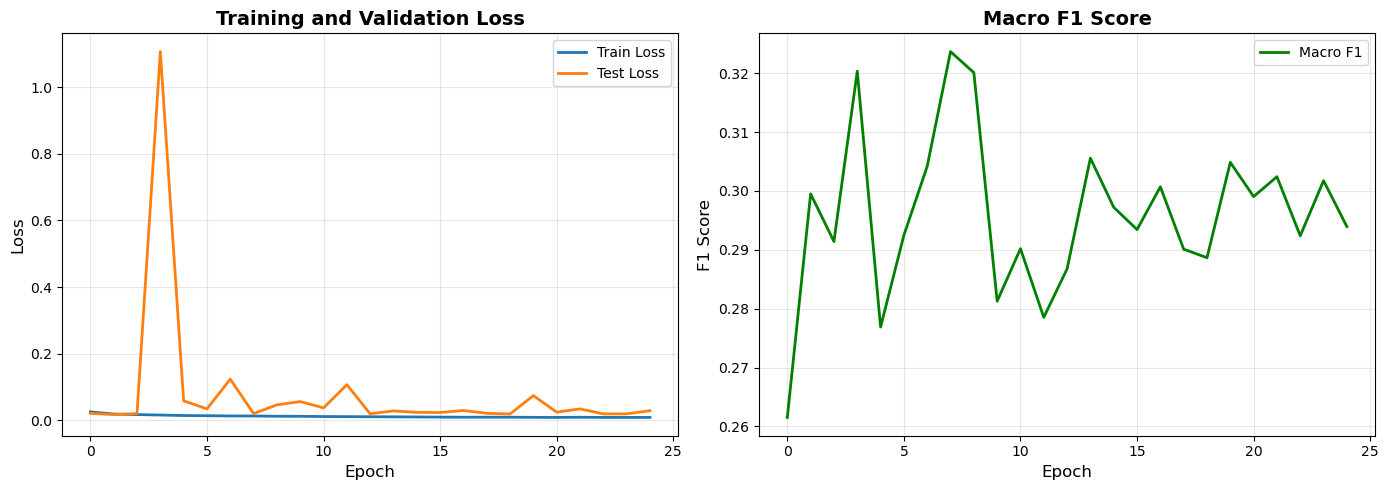


STEP 6: Final Evaluation on Test Set


Evaluating: 100%|██████████| 7/7 [00:04<00:00,  1.48it/s]



--------------------------Metrics Per Class----------------------------------------------------------
Bent                      | P: 0.333 | R: 0.208 | F1: 0.256 | Acc: 0.734 | Support: 48
Exotic                    | P: 0.500 | R: 0.400 | F1: 0.444 | Acc: 0.977 | Support: 5
FR I                      | P: 0.400 | R: 0.471 | F1: 0.432 | Acc: 0.807 | Support: 34
FR II                     | P: 0.727 | R: 0.580 | F1: 0.645 | Acc: 0.798 | Support: 69
Point Source              | P: 0.816 | R: 0.596 | F1: 0.689 | Acc: 0.872 | Support: 52
S/Z shaped                | P: 0.000 | R: 0.000 | F1: 0.000 | Acc: 0.986 | Support: 3
Should be discarded       | P: 0.500 | R: 0.043 | F1: 0.080 | Acc: 0.894 | Support: 23
X-Shaped                  | P: 0.000 | R: 0.000 | F1: 0.000 | Acc: 1.000 | Support: 0
typical                   | P: 0.000 | R: 0.000 | F1: 0.000 | Acc: 0.991 | Support: 2

-------------------Overall Metrics-------------------------------------------------------
Hamming Loss:        0.1045

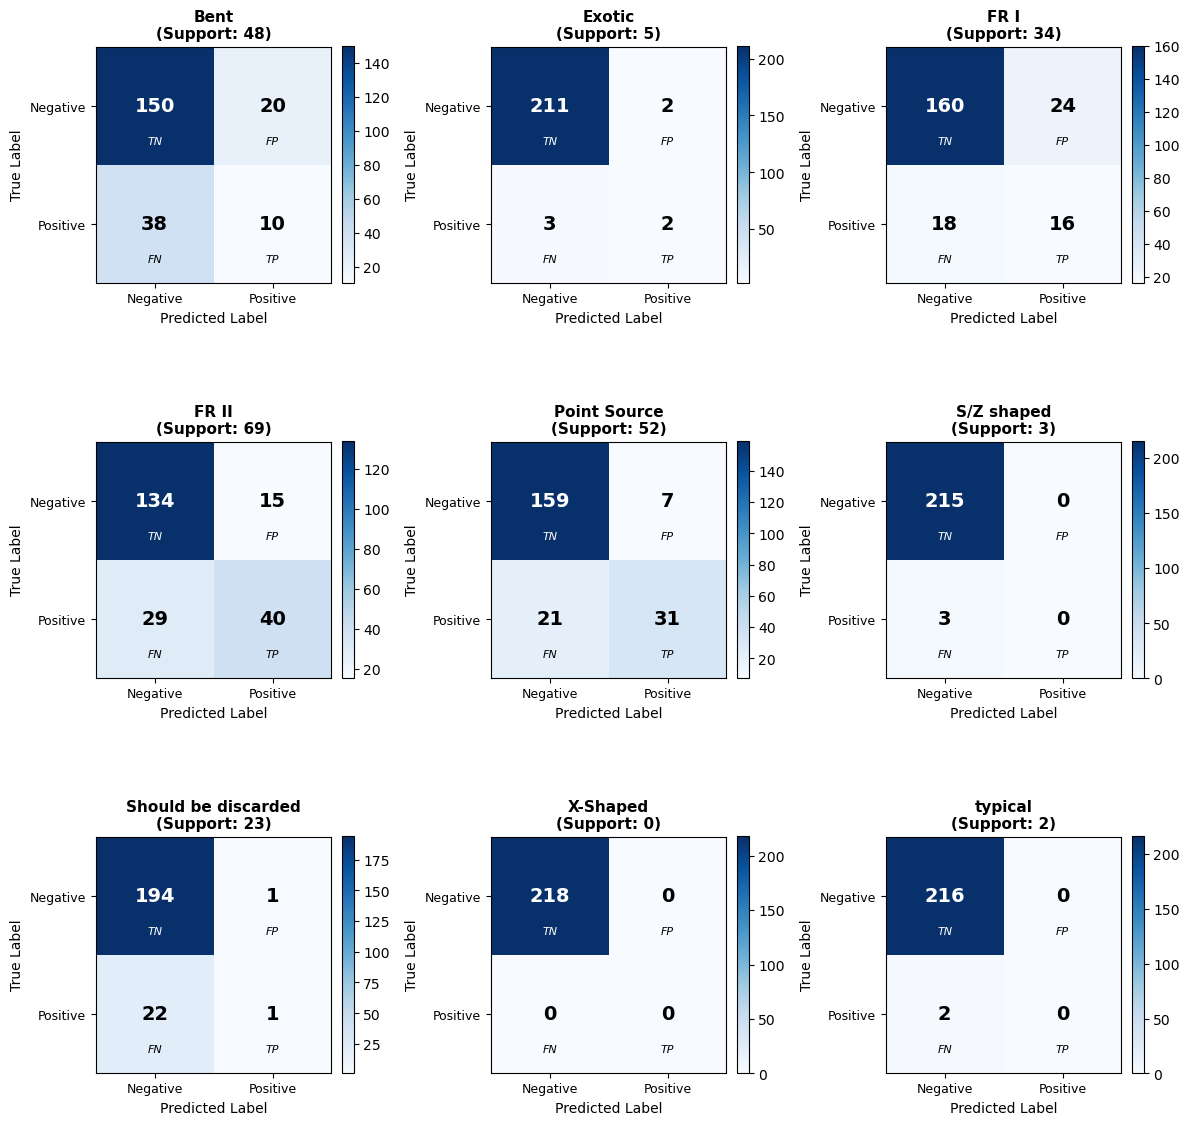


-------------------------Confusion Matrix Summary---------------------------------------------------------

Class                     |     TP |     FP |     FN |     TN | Sensitivity | Specificity
--------------------------------------------------------------------------------
Bent                      |     10 |     20 |     38 |    150 |       0.208 |       0.882
Exotic                    |      2 |      2 |      3 |    211 |       0.400 |       0.991
FR I                      |     16 |     24 |     18 |    160 |       0.471 |       0.870
FR II                     |     40 |     15 |     29 |    134 |       0.580 |       0.899
Point Source              |     31 |      7 |     21 |    159 |       0.596 |       0.958
S/Z shaped                |      0 |      0 |      3 |    215 |       0.000 |       1.000
Should be discarded       |      1 |      1 |     22 |    194 |       0.043 |       0.995
X-Shaped                  |      0 |      0 |      0 |    218 |       0.000 |       1.000


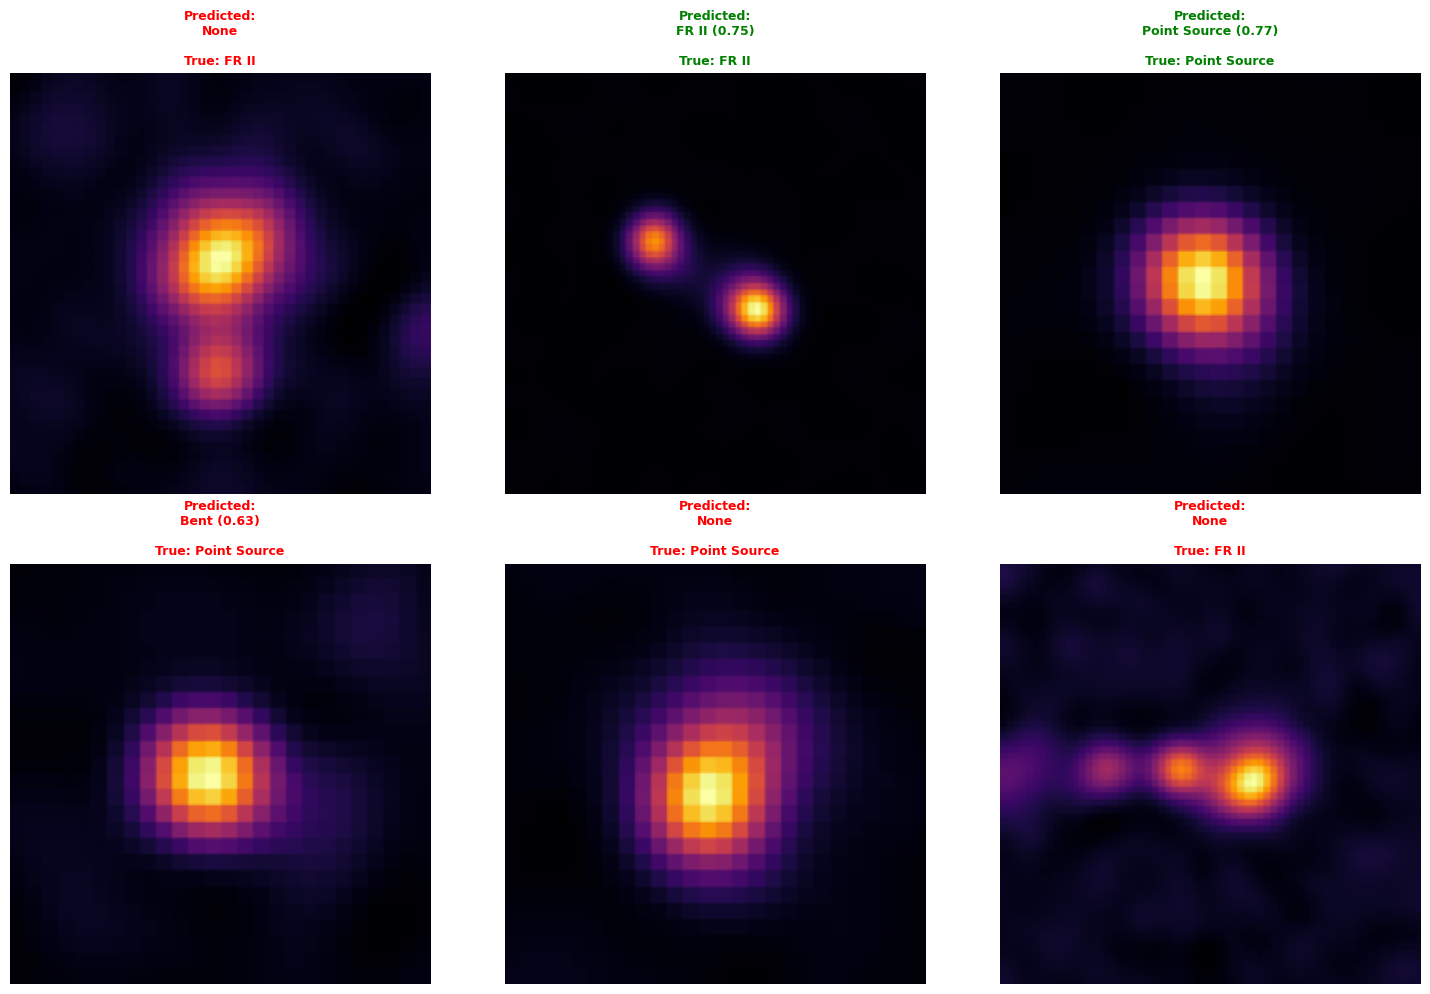


----------------------------------------Predicting on Test.csv--------------------------------------------

Loaded 100 test coordinates


Predicting on provided test.csv: 100%|██████████| 4/4 [00:02<00:00,  1.80it/s]


Saved predictions to test_labels.csv
 Predictions saved for 100 test samples

--------------------------------TRAINING COMPLETE!---------------------------------------------------


Best model saved to: best_model.pth
Best validation macro F1: 0.3237
Achieved at epoch: 8


In [18]:
if __name__ == "__main__":
    
    # SET SEED FIRST
    SEED = 42
    set_seed(SEED)
    
    # Configuration
    LABELS_PATH = "labels.csv"
    IMAGE_FOLDERS = ["typ/typ_PNG/", "exo/exo_PNG/"]
    TEST_CSV_PATH = "test.csv"
    BATCH_SIZE = 32
    NUM_EPOCHS = 25
    LEARNING_RATE = 1e-4
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    print(f"Using device: {DEVICE}\n")
    
    # Step 1: Load and match labels
    print("\n----------------------------Loading Datasets >> Matching Labels---------------------------------------------\n")

    labels, files_df = load_and_match_labels(LABELS_PATH, IMAGE_FOLDERS)
    
    # Step 2: Transform to binary
    labels_binary, label_columns = transform_labels_to_binary(labels)
    
    print(f"\nDataset Overview:")
    print(f"  Total samples: {len(labels_binary)}")
    print(f"  Number of classes: {len(label_columns)}")
    print(f"  Classes: {', '.join(label_columns)}")
    
    # Step 3: Split into train/test (90/10 split)
    print("\n-------------------------------Train/Test Split----------------------------------------\n")
    
    train_df = labels_binary.sample(frac=0.9, random_state=SEED)
    test_df = labels_binary.drop(train_df.index)
    
    print(f"Train set: {len(train_df)} samples (90%)")
    print(f"Test set:  {len(test_df)} samples (10%)")
    
    # Step 4: Create model
    print("\n--------------------------------------------------Model Creation----------------------------------------\n")

    
    num_classes = len(label_columns)
    model = EfficientNetMultiLabel(num_classes=num_classes, pretrained=True)
    model = model.to(DEVICE)
    
    print(f"Model: EfficientNet-B2 with {num_classes} output classes")
    print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
    print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
    
    # Step 5: Train model with ALL imbalance fixes
    print("\n-------------------------------------Training------------------------------------------------------------------")

    model, train_losses, test_losses, f1_scores, checkpoint = train_all(
        model=model,
        train_df=train_df,
        label_columns=label_columns,
        device=DEVICE,
        num_epochs=NUM_EPOCHS,
        learning_rate=LEARNING_RATE,
        batch_size=BATCH_SIZE,
        use_focal_loss=True,           # Use Focal Loss instead of BCE
        sampler_alpha=0.75,             # Aggressive oversampling of rare classes
        eval_threshold=0.3,             # Lower threshold for rare class detection
        val_split=0.0,                  # NO validation split
        save_path='best_model.pth',
        test_df=test_df                 # Pass test_df for evaluation
    )
    
    # Step 6: Plot training curves
    print("\n" + "="*80)
    print("\n--------------------------------------Training Curves------------------------------------------------\n ")
    print("="*80)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Loss plot
    axes[0].plot(train_losses, label='Train Loss', linewidth=2)
    axes[0].plot(test_losses, label='Test Loss', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # F1 score plot
    axes[1].plot(f1_scores, label='Macro F1', linewidth=2, color='green')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('F1 Score', fontsize=12)
    axes[1].set_title('Macro F1 Score', fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
    print("✓ Training curves saved to 'training_curves.png'")
    plt.show()
    
    # Step 7: Final evaluation on held-out test set
    print("\n" + "="*80)
    print("STEP 6: Final Evaluation on Test Set")
    print("="*80)
    
    # Create test dataloader
    test_dataset = RadioDataset(
        df=test_df,
        label_columns=label_columns,
        mode='test'
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=0
    )
    
    # Evaluate
    test_preds, test_labels, test_probs, results = evaluate_model(
        model, test_loader, label_columns, DEVICE, show_confusion_matrix=True
    )
    
    print_confusion_matrix_summary(results, label_columns)
    
    # Step 8: Visualize predictions
    print("\n-------------------------------------Visualizing Sample Predictions-------------------------------------\n")
    
    visualize_predictions(model, test_dataset, label_columns, DEVICE, num_samples=6)
    
    # Step 9: Predict on provided test.csv (if exists)
    if os.path.exists(TEST_CSV_PATH):
        print("\n----------------------------------------Predicting on Test.csv--------------------------------------------\n")
        
        test_csv_predictions = predict_provided_test_set(
            model, TEST_CSV_PATH, IMAGE_FOLDERS, label_columns, DEVICE
        )
        
        print(f" Predictions saved for {len(test_csv_predictions)} test samples")
    
    print("\n--------------------------------TRAINING COMPLETE!---------------------------------------------------\n")
    print(f"\nBest model saved to: best_model.pth")
    print(f"Best validation macro F1: {checkpoint['macro_f1']:.4f}")
    print(f"Achieved at epoch: {checkpoint['epoch'] + 1}")

### Pseudo-Labeling

In [23]:
def pseudo_label_unlabeled(model, unlabeled_folder, label_columns, device, 
                           confidence_threshold=0.8, output_path='generated_labels.csv'):
    """
    Generate pseudo-labels for ALL unlabeled images
    
    Args:
        model: trained model
        unlabeled_folder: path to folder with unlabeled images
        label_columns: list of label names
        device: torch device
        confidence_threshold: minimum confidence to consider (for filtering, optional)
        output_path: where to save the labels
    
    Returns:
        DataFrame with coordinates, predictions, and confidence scores
    """
    
    print(f"\nScanning unlabeled folder: {unlabeled_folder}")
    
    # Collect all image files with coordinates
    file_entries = []
    for fname in os.listdir(unlabeled_folder):
        if fname.endswith((".fits", ".FITS", ".png", ".PNG")):
            x, y = extract_filename(fname)
            if x is not None and y is not None:
                file_entries.append({
                    'filename': fname,
                    'x_coord': x,
                    'y_coord': y,
                    'folder_path': unlabeled_folder
                })
    
    unlabeled_df = pd.DataFrame(file_entries)
    print(f"Found {len(unlabeled_df)} unlabeled images")
    
    if len(unlabeled_df) == 0:
        print("No images found!")
        return pd.DataFrame()
    
    # Add columns for matching
    unlabeled_df['matched_filename'] = unlabeled_df['filename']
    unlabeled_df['matched_folder'] = unlabeled_df['folder_path']
    
    # Initialize label columns with 0s
    for label in label_columns:
        unlabeled_df[label] = 0
    
    # Create dataset in test mode
    unlabeled_dataset = RadioDataset(
        df=unlabeled_df,
        label_columns=label_columns,
        mode='test'
    )
    unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=32, shuffle=False, num_workers=0)
    
    # Generate predictions
    model.eval()
    all_probs = []
    
    print("\nGenerating pseudo-labels...")
    with torch.no_grad():
        for images, _ in tqdm(unlabeled_loader, desc="Processing"):
            outputs = model(images.to(device))
            probs = torch.sigmoid(outputs).cpu().numpy()
            all_probs.append(probs)
    
    all_probs = np.vstack(all_probs)
    
    # Get predictions (threshold at 0.5)
    all_preds = (all_probs > 0.5).astype(int)
    
    # Calculate confidence (max probability per sample)
    confidence_scores = np.max(all_probs, axis=1)
    
  def pseudo_label_unlabeled(model, unlabeled_folder, label_columns, device, 
                           confidence_threshold=0.8, output_path='generated_labels.csv'):
    """
    Generate pseudo-labels for ALL unlabeled images
    
    Args:
        model: trained model
        unlabeled_folder: path to folder with unlabeled images
        label_columns: list of label names
        device: torch device
        confidence_threshold: minimum confidence to consider (for filtering, optional)
        output_path: where to save the labels
    
    Returns:
        DataFrame with coordinates, predictions, and confidence scores
    """
    
    print(f"\nScanning unlabeled folder: {unlabeled_folder}")
    
    # Collect all image files with coordinates
    file_entries = []
    for fname in os.listdir(unlabeled_folder):
        if fname.endswith((".fits", ".FITS", ".png", ".PNG")):
            x, y = extract_filename(fname)
            if x is not None and y is not None:
                file_entries.append({
                    'filename': fname,
                    'x_coord': x,
                    'y_coord': y,
                    'folder_path': unlabeled_folder
                })
    
    unlabeled_df = pd.DataFrame(file_entries)
    print(f"Found {len(unlabeled_df)} unlabeled images")
    
    if len(unlabeled_df) == 0:
        print("No images found!")
        return pd.DataFrame()
    
    # Add columns for matching
    unlabeled_df['matched_filename'] = unlabeled_df['filename']
    unlabeled_df['matched_folder'] = unlabeled_df['folder_path']
    
    # Initialize label columns with 0s
    for label in label_columns:
        unlabeled_df[label] = 0
    
    # Create dataset in test mode
    unlabeled_dataset = RadioDataset(
        df=unlabeled_df,
        label_columns=label_columns,
        mode='test'
    )
    unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=32, shuffle=False, num_workers=0)
    
    # Generate predictions
    model.eval()
    all_probs = []
    
    print("\nGenerating pseudo-labels...")
    with torch.no_grad():
        for images, _ in tqdm(unlabeled_loader, desc="Processing"):
            outputs = model(images.to(device))
            probs = torch.sigmoid(outputs).cpu().numpy()
            all_probs.append(probs)
    
    all_probs = np.vstack(all_probs)
    
    # Get predictions (threshold at 0.5)
    all_preds = (all_probs > 0.5).astype(int)
    
    # Calculate MULTIPLE confidence metrics
    # Method 1: Max probability (original)
    max_prob = np.max(all_probs, axis=1)
    
    # Method 2: Mean probability of predicted classes
    mean_prob_predicted = []
    for i in range(len(all_probs)):
        predicted_mask = all_preds[i] == 1
        if predicted_mask.sum() > 0:
            mean_prob_predicted.append(all_probs[i][predicted_mask].mean())
        else:
            # No predictions - use inverse of max probability for negative classes
            mean_prob_predicted.append(1 - np.max(all_probs[i]))
    mean_prob_predicted = np.array(mean_prob_predicted)
    
    # Method 3: Min probability of predicted classes (most conservative)
    min_prob_predicted = []
    for i in range(len(all_probs)):
        predicted_mask = all_preds[i] == 1
        if predicted_mask.sum() > 0:
            min_prob_predicted.append(all_probs[i][predicted_mask].min())
        else:
            min_prob_predicted.append(1 - np.max(all_probs[i]))
    min_prob_predicted = np.array(min_prob_predicted)
    
    # Add predictions and confidence to dataframe
    for i, label in enumerate(label_columns):
        unlabeled_df[label] = all_preds[:, i]
    
    unlabeled_df['confidence_max'] = max_prob
    unlabeled_df['confidence_mean'] = mean_prob_predicted
    unlabeled_df['confidence_min'] = min_prob_predicted
    unlabeled_df['confidence'] = mean_prob_predicted  # Use mean as default
    unlabeled_df['num_labels'] = all_preds.sum(axis=1)
    
    # Create output with required format
    output_df = unlabeled_df[['x_coord', 'y_coord'] + label_columns].copy()
    
    # Save ALL labels
    output_df.to_csv(output_path, index=False)
    print(f"\n✓ Saved ALL {len(output_df)} pseudo-labels to {output_path}")
    
    # Print statistics
    print("\n" + "="*80)
    print("Pseudo-Labeling Statistics")
    print("="*80)
    print(f"Total samples: {len(unlabeled_df)}")
    print(f"\nConfidence scores (using mean of predicted class probabilities):")
    print(f"  Mean:   {mean_prob_predicted.mean():.3f}")
    print(f"  Median: {np.median(mean_prob_predicted):.3f}")
    print(f"  Min:    {mean_prob_predicted.min():.3f}")
    print(f"  Max:    {mean_prob_predicted.max():.3f}")
    
    print(f"\nSamples by confidence threshold:")
    for thresh in [0.5, 0.6, 0.7, 0.8, 0.9]:
        count = (mean_prob_predicted > thresh).sum()
        pct = count / len(unlabeled_df) * 100
        print(f"  > {thresh}: {count:6d} samples ({pct:5.1f}%)")
    
    print(f"\nLabel distribution (ALL samples):")
    for label in label_columns:
        count = unlabeled_df[label].sum()
        print(f"  {label:25s}: {count:5d} ({count/len(unlabeled_df)*100:.1f}%)")
    
    print(f"\nMulti-label statistics:")
    print(f"  Samples with 0 labels:  {(unlabeled_df['num_labels'] == 0).sum()}")
    print(f"  Samples with 1 label:   {(unlabeled_df['num_labels'] == 1).sum()}")
    print(f"  Samples with 2+ labels: {(unlabeled_df['num_labels'] > 1).sum()}")
    
    # Also save a detailed version with confidence scores
    detailed_path = output_path.replace('.csv', '_detailed.csv')
    unlabeled_df[['x_coord', 'y_coord', 'filename'] + label_columns + 
                 ['confidence_max', 'confidence_mean', 'confidence_min', 'num_labels']].to_csv(
        detailed_path, index=False
    )
    print(f"\n✓ Saved detailed version to {detailed_path}")
    print("  (includes all confidence metrics)")
    print("="*80)
    
    # Return full dataframe for optional retraining
    return unlabeled_df

### Pseudo-Labelling



Do you want to perform pseudo-labeling? (y/n):  y



---------------Pseudo-Labeling On Unlabeled Dataset----------------------------------------------

Scanning unlabeled folder: unl/unl_PNG/
Found 13821 unlabeled images

Generating pseudo-labels...


Processing: 100%|██████████| 432/432 [05:19<00:00,  1.35it/s]



 Saved ALL 13821 pseudo-labels to generated_labels.csv

Pseudo-Labeling Statistics
Total samples: 13821
Average confidence: 0.554
High confidence (>0.8): 105

Label distribution (ALL samples):
  Bent: 1995 (14.4%)
  Exotic: 232 (1.7%)
  FR I: 2742 (19.8%)
  FR II: 4281 (31.0%)
  Point Source: 767 (5.5%)
  S/Z shaped: 22 (0.2%)
  Should be discarded: 109 (0.8%)
  X-Shaped: 12 (0.1%)
  typical: 67 (0.5%)

Samples with multiple labels: 542
Samples with no labels: 4139

 Saved detailed version to generated_labels_detailed.csv
  (includes confidence scores and statistics)


Do you want to RETRAIN model with high-confidence pseudo-labels? (y/n):  y



-------------------------------------Retraining----------------------------------------

Using 7 high-confidence samples (confidence > 0.9)
Original training set: 1960 samples
Combined training set: 1967 samples

Fine-tuning for 15 more epochs...

----------------------Training----------------------------------------


Dataset split:
  Training: 1967 samples (using full training set)
  Test:     218 samples (external test set for evaluation)

-----------------------------------Creating Balanced Sampler-----------------------------------

Label frequencies:
  X-Shaped                 :    6 samples
  S/Z shaped               :   20 samples
  typical                  :   22 samples
  Exotic                   :   58 samples
  Should be discarded      :  177 samples
  Point Source             :  390 samples
  FR I                     :  397 samples
  Bent                     :  477 samples
  FR II                    :  615 samples

Sample weight statistics:
  Min weight: 0.5976
  Max weig

Epoch 1/15: 100%|██████████| 62/62 [04:03<00:00,  3.92s/it, loss=0.0205]



Epoch 1/15
  Train Loss: 0.0123
  Test Loss:   0.0776
  Macro F1:   0.2904
  New best model saved (F1: 0.2904)



Epoch 2/15: 100%|██████████| 62/62 [03:58<00:00,  3.85s/it, loss=0.0137]



Epoch 2/15
  Train Loss: 0.0120
  Test Loss:   0.0178
  Macro F1:   0.2771



Epoch 3/15: 100%|██████████| 62/62 [03:57<00:00,  3.82s/it, loss=0.0092]



Epoch 3/15
  Train Loss: 0.0116
  Test Loss:   0.0200
  Macro F1:   0.2800



Epoch 4/15: 100%|██████████| 62/62 [03:58<00:00,  3.84s/it, loss=0.0085]



Epoch 4/15
  Train Loss: 0.0109
  Test Loss:   0.0186
  Macro F1:   0.2851



Epoch 5/15: 100%|██████████| 62/62 [03:51<00:00,  3.74s/it, loss=0.0073]



Epoch 5/15
  Train Loss: 0.0108
  Test Loss:   0.0432
  Macro F1:   0.2871



Epoch 6/15: 100%|██████████| 62/62 [03:46<00:00,  3.66s/it, loss=0.0076]



Epoch 6/15
  Train Loss: 0.0106
  Test Loss:   0.0266
  Macro F1:   0.2833



Epoch 7/15: 100%|██████████| 62/62 [03:50<00:00,  3.72s/it, loss=0.0108]



Epoch 7/15
  Train Loss: 0.0104
  Test Loss:   0.0182
  Macro F1:   0.2837



Epoch 8/15: 100%|██████████| 62/62 [03:51<00:00,  3.73s/it, loss=0.0117]



Epoch 8/15
  Train Loss: 0.0102
  Test Loss:   0.0183
  Macro F1:   0.2822



Epoch 9/15: 100%|██████████| 62/62 [03:54<00:00,  3.79s/it, loss=0.0147]



Epoch 9/15
  Train Loss: 0.0099
  Test Loss:   0.0432
  Macro F1:   0.2891



Epoch 10/15: 100%|██████████| 62/62 [03:55<00:00,  3.80s/it, loss=0.0127]



Epoch 10/15
  Train Loss: 0.0100
  Test Loss:   0.0186
  Macro F1:   0.2929
  New best model saved (F1: 0.2929)



Epoch 11/15: 100%|██████████| 62/62 [03:57<00:00,  3.84s/it, loss=0.0083]



Epoch 11/15
  Train Loss: 0.0098
  Test Loss:   0.0848
  Macro F1:   0.2936
  New best model saved (F1: 0.2936)



Epoch 12/15: 100%|██████████| 62/62 [03:53<00:00,  3.77s/it, loss=0.0074]



Epoch 12/15
  Train Loss: 0.0095
  Test Loss:   0.2196
  Macro F1:   0.2957
  New best model saved (F1: 0.2957)



Epoch 13/15: 100%|██████████| 62/62 [03:52<00:00,  3.75s/it, loss=0.0105]



Epoch 13/15
  Train Loss: 0.0101
  Test Loss:   0.0396
  Macro F1:   0.2881



Epoch 14/15: 100%|██████████| 62/62 [03:51<00:00,  3.73s/it, loss=0.0124]



Epoch 14/15
  Train Loss: 0.0096
  Test Loss:   0.2155
  Macro F1:   0.2877



Epoch 15/15: 100%|██████████| 62/62 [03:56<00:00,  3.82s/it, loss=0.0069]



Epoch 15/15
  Train Loss: 0.0095
  Test Loss:   0.0191
  Macro F1:   0.2913


✓ Loaded best model from best_model_finetuned.pth

Final per-class F1 scores:
  Bent                     : 0.448
  Exotic                   : 0.267
  FR I                     : 0.429
  FR II                    : 0.650
  Point Source             : 0.639
  S/Z shaped               : 0.000
  Should be discarded      : 0.229
  X-Shaped                 : 0.000
  typical                  : 0.000

------------------------------------Final Evaluation---------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:04<00:00,  1.59it/s]



--------------------------Metrics Per Class----------------------------------------------------------
Bent                      | P: 0.343 | R: 0.250 | F1: 0.289 | Acc: 0.729 | Support: 48
Exotic                    | P: 0.500 | R: 0.400 | F1: 0.444 | Acc: 0.977 | Support: 5
FR I                      | P: 0.514 | R: 0.529 | F1: 0.522 | Acc: 0.849 | Support: 34
FR II                     | P: 0.638 | R: 0.638 | F1: 0.638 | Acc: 0.771 | Support: 69
Point Source              | P: 0.800 | R: 0.538 | F1: 0.644 | Acc: 0.858 | Support: 52
S/Z shaped                | P: 0.000 | R: 0.000 | F1: 0.000 | Acc: 0.986 | Support: 3
Should be discarded       | P: 0.167 | R: 0.043 | F1: 0.069 | Acc: 0.876 | Support: 23
X-Shaped                  | P: 0.000 | R: 0.000 | F1: 0.000 | Acc: 1.000 | Support: 0
typical                   | P: 0.000 | R: 0.000 | F1: 0.000 | Acc: 0.991 | Support: 2

-------------------Overall Metrics-------------------------------------------------------
Hamming Loss:        0.1070

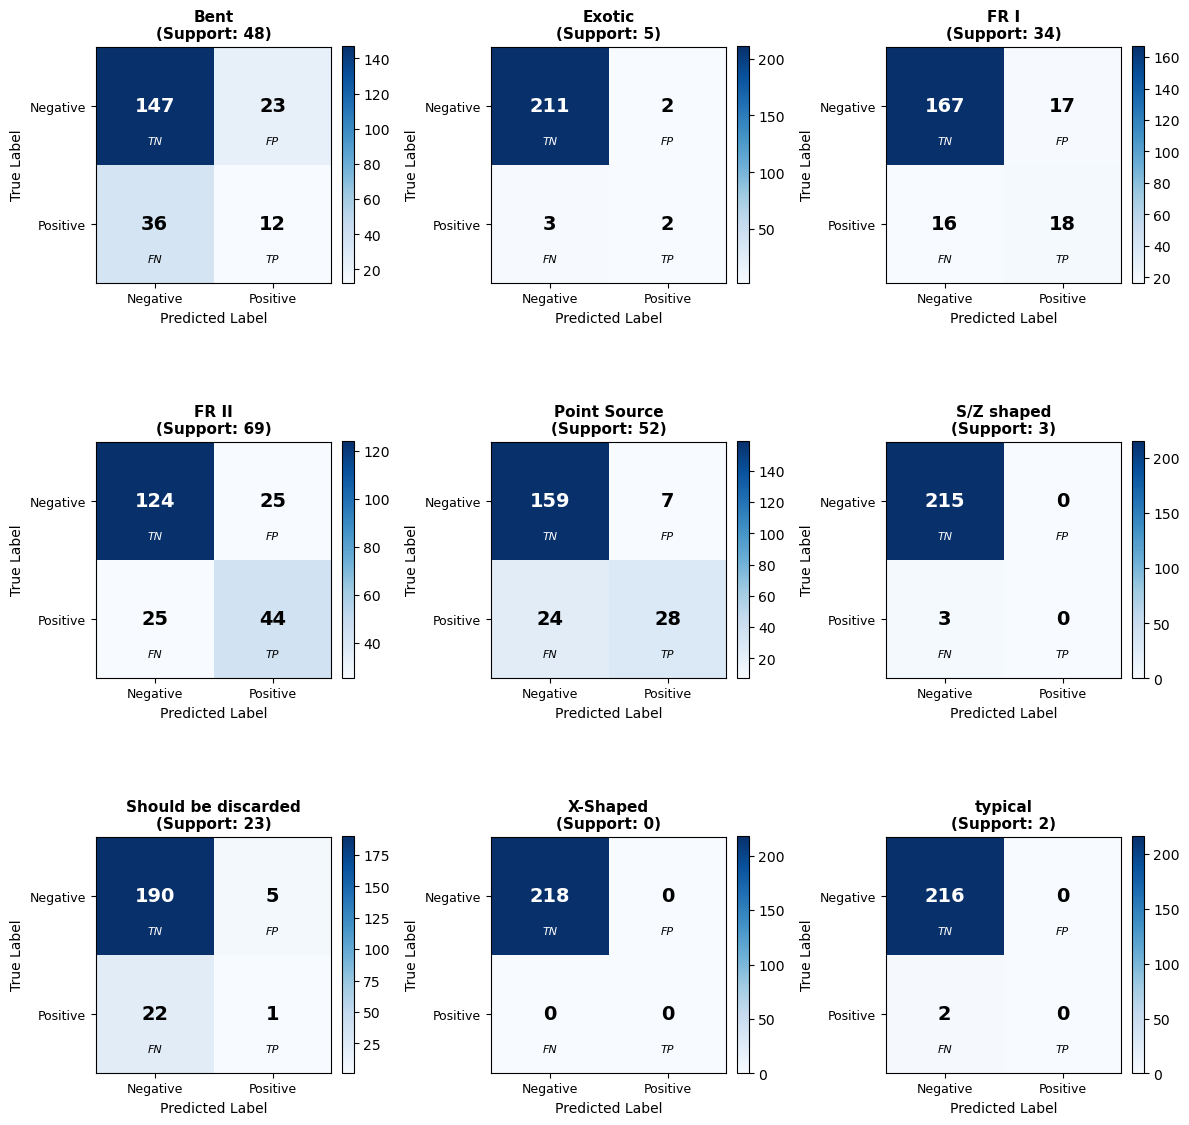


-------------------------Confusion Matrix Summary---------------------------------------------------------

Class                     |     TP |     FP |     FN |     TN | Sensitivity | Specificity
--------------------------------------------------------------------------------
Bent                      |     12 |     23 |     36 |    147 |       0.250 |       0.865
Exotic                    |      2 |      2 |      3 |    211 |       0.400 |       0.991
FR I                      |     18 |     17 |     16 |    167 |       0.529 |       0.908
FR II                     |     44 |     25 |     25 |    124 |       0.638 |       0.832
Point Source              |     28 |      7 |     24 |    159 |       0.538 |       0.958
S/Z shaped                |      0 |      0 |      3 |    215 |       0.000 |       1.000
Should be discarded       |      1 |      5 |     22 |    190 |       0.043 |       0.974
X-Shaped                  |      0 |      0 |      0 |    218 |       0.000 |       1.000


In [24]:
UNLABELED_FOLDER = "unl/unl_PNG/"  # Update this path
USE_PSEUDO_LABELING = input("\n\nDo you want to perform pseudo-labeling? (y/n): ").lower() == 'y'
    
if USE_PSEUDO_LABELING and os.path.exists(UNLABELED_FOLDER):
        print("\n---------------Pseudo-Labeling On Unlabeled Dataset----------------------------------------------")
     
        
        # Generate labels for ALL unlabeled images
        pseudo_labeled_df = pseudo_label_unlabeled(
            model=model,
            unlabeled_folder=UNLABELED_FOLDER,
            label_columns=label_columns,
            device=DEVICE,
            confidence_threshold=0.8,
            output_path='generated_labels.csv'
        )
        
        # Ask if user wants to retrain with high-confidence samples
        retrain = input("Do you want to RETRAIN model with high-confidence pseudo-labels? (y/n): ").lower() == 'y'
        
           
        if retrain:
            print("\n-------------------------------------Retraining----------------------------------------")
 
            
            # Filter for high-confidence samples
            high_confidence = pseudo_labeled_df[pseudo_labeled_df['confidence'] > 0.9].copy()
            print(f"\nUsing {len(high_confidence)} high-confidence samples (confidence > 0.9)")
            print(f"Original training set: {len(train_df)} samples")
            
            # Combine with original training data
            combined_train_df = pd.concat([train_df, high_confidence], ignore_index=True)
            print(f"Combined training set: {len(combined_train_df)} samples")
            
            # Create new dataset
            combined_dataset = RadioDataset(
                df=combined_train_df,
                label_columns=label_columns,
                mode='train'
            )
            
            # Create new dataloader
            combined_loader = DataLoader(
                combined_dataset,
                batch_size=32,
                shuffle=True,)
            
            # Create new model (or load best checkpoint and continue)
            model_retrain = EfficientNetMultiLabel(num_classes=num_classes, pretrained=False)
            model_retrain.load_state_dict(checkpoint['model_state_dict'])  # Start from best model
            model_retrain = model_retrain.to(DEVICE)
            
            # Use same optimizer and loss
            optimizer_retrain = torch.optim.Adam(model_retrain.parameters(), lr=LEARNING_RATE/2)  # Lower LR for fine-tuning
            
            # Train for fewer epochs (fine-tuning)
            print("\nFine-tuning for 15 more epochs...")
            model_retrain, train_losses_ft, test_losses_ft, f1_scores_ft, checkpoint_ft = train_all(
            model=model_retrain,
            train_df=combined_train_df,  # Combined dataset
            label_columns=label_columns,
            device=DEVICE,
            num_epochs=15,  # Fewer epochs for fine-tuning
            learning_rate=LEARNING_RATE / 2,  # Lower LR
            batch_size=BATCH_SIZE,
            use_focal_loss=True,
            sampler_alpha=0.75,
            eval_threshold=0.3,
            val_split=0.0,
            test_df=test_df,  # Same test set
            save_path='best_model_finetuned.pth'
        )

            # Final evaluation with fine-tuned model
            print("\n------------------------------------Final Evaluation---------------------------------------------------")
            
            checkpoint_ft = torch.load('best_model_finetuned.pth')
            model_retrain.load_state_dict(checkpoint_ft['model_state_dict'])
            
            test_preds_ft, test_labels_ft, test_probs_ft, results_ft = evaluate_model(
                model_retrain, test_loader, label_columns, DEVICE, show_confusion_matrix=True
            )
            
            print_confusion_matrix_summary(results_ft, label_columns)
            
            # Use fine-tuned model for final predictions
            model = model_retrain
    
elif USE_PSEUDO_LABELING:
        print(f"\nUnlabeled folder not found: {UNLABELED_FOLDER}")
        print("Skipping pseudo-labeling step.")
